# Requirements

In [279]:
import pandas as pd
import numpy as np
import requests
import re
import json
import random
import scipy
import pickle

import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec
from copydf import copyDF

from nltk import ngrams

import seaborn as sns
import geoplot as gplt

import warnings
warnings.filterwarnings('ignore')

import sddk
import tempun

# Import the dataset

In [121]:
LIRE = gpd.read_parquet("../data/large_files/LIRE_deities.parquet")
# alternatively, use GeoJSON - it is more memory consuming, but it has been tested
# LIRE = gpd.read_file("../data/large_files/LIRE_deities.geojson", driver="GeoJSON")

In [122]:
LIRE.shape

(137305, 115)

In [126]:
LIRE["asclepius"].sum()

210

In [127]:
LIRE[(LIRE["asclepius"]) & (LIRE["type_of_inscription_auto"] =="epitaph")]

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,city_pop_est,city_geometry,nearest_city_type,nearest_city_dist,type_of_inscription_auto,type_of_inscription_auto_prob,geometry,asclepius,apollo,jupiter
63964,EDCS-21100456,"CIL 11, 07584",Etruria / Regio VII,Etruria / Regio VII,Civitavecchia / Centumcellae / Blera,"['Civitavecchia', 'Centumcellae', 'Blera']",270,,[tituli sepulcrales],[tituli sepulcrales],...,1989.0,"[11.796814, 42.09118]",middle,0.005242,epitaph,1.00,POINT (11.79225 42.09375),True,False,False
73825,EDCS-28300277,"IPOstie-A, 00142 = ISIS 00178 = CCCA-03, 00445",Latium et Campania / Regio I,Latium et Campania / Regio I,Fiumicino / Portus,"['Fiumicino', 'Portus']",138,,"[mulieres, viri]",[],...,1559.0,"[12.266667, 41.779167]",middle,0.034716,epitaph,0.97,POINT (12.23395 41.76757),True,False,False
92537,EDCS-18100945,"CIL 06, 02231",Roma,Roma,Roma,Roma,400,,"[sacerdotes pagani, tituli sacri, tituli sepul...","[tituli sacri, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,0.96,POINT (12.48293 41.89332),True,False,False
99326,EDCS-14800719,"CIL 06, 12505 (p 3511)",Roma,Roma,Roma,Roma,200,,"[mulieres, tituli sepulcrales, viri]",[tituli sepulcrales],...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
101216,EDCS-00600441,"CIL 06, 17441 = ICUR-06, 17407",Roma,Roma,Roma,Roma,500,,"[inscriptiones christianae, mulieres, nomen si...","[inscriptiones christianae, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
112317,EDCS-38700949,"ICUR-01, 00549",Roma,Roma,Roma,Roma,400,,"[inscriptiones christianae, mulieres, nomen si...","[inscriptiones christianae, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
116921,EDCS-34800518,"ICUR-03, 07043b",Roma,Roma,Roma,Roma,500,,"[inscriptiones christianae, tituli sepulcrales...","[inscriptiones christianae, tituli sepulcrales]",...,923313.0,"[12.485098, 41.892777]",big,0.002233,epitaph,1.00,POINT (12.48293 41.89332),True,False,False
127677,EDCS-22200434,"CIL 10, 07604 = IFPK 00196 = SRD 00088 = Porra...",Sardinia,Sardinia,Casteddu / Cagliari / Carales,"['Casteddu', 'Cagliari', 'Carales']",230,,"[mulieres, sacerdotes pagani, tituli sacri, ti...","[tituli sacri, tituli sepulcrales]",...,1000.0,"[9.104227, 39.220021]",minor,0.009154,epitaph,0.64,POINT (9.11285 39.21695),True,False,False


In [128]:
print(list(LIRE.columns))

['EDCS-ID', 'publication', 'province', 'province_list', 'place', 'place_list', 'end_yr_list', 'notes_dating', 'status_list', 'inscr_type', 'status_notation', 'inscr_process', 'notes_references', 'notes_comments', 'inscription', 'inscription_stripped_final', 'Links', 'dating from', 'dating to', 'status', 'Latitude', 'Longitude', 'photo', 'Material', 'Comment', 'EDH-ID', 'language_EDCS', 'clean_text_interpretive_word_EDCS', 'responsible_individual', 'type_of_inscription', 'letter_size', 'literature', 'work_status', 'height', 'diplomatic_text', 'people', 'depth', 'material', 'type_of_monument', 'province_label', 'width', 'transcription', 'country', 'uri', 'findspot_ancient', 'last_update', 'modern_region', 'findspot_modern', 'edh_geography_uri', 'commentary', 'trismegistos_uri', 'external_image_uris', 'fotos', 'idno_tm', 'placenames_refs', 'text_edition', 'origdate_text', 'layout_execution', 'layout_execution_text', 'support_objecttype', 'support_objecttype_text', 'support_material', 'sup

# Static explorations of the dataset


In [129]:
deities_inscr_types = [dict(LIRE[LIRE["asclepius"]].groupby("type_of_inscription_auto").size()),
                       dict(LIRE[LIRE["apollo"]].groupby("type_of_inscription_auto").size()),
                       dict(LIRE[LIRE["jupiter"]].groupby("type_of_inscription_auto").size()),
                      dict(LIRE.groupby("type_of_inscription_auto").size())]

In [130]:
deities_inscr_types[0]

{'building/dedicatory inscription': 10,
 'defixio': 1,
 'epitaph': 8,
 'honorific inscription': 2,
 'votive inscription': 176}

In [131]:
deities_inscr_types_df = pd.DataFrame(deities_inscr_types)
deities_inscr_types_df.fillna(0, inplace=True)
deities_inscr_types_df = deities_inscr_types_df.astype(int)
deities_inscr_types_df.index = ["asclepius", "apollo", "jupiter", "LIRE_all"]
deities_inscr_types_df = deities_inscr_types_df.T
deities_inscr_types_df.sort_values("asclepius", ascending=False, inplace=True)
deities_inscr_types_df

,asclepius,apollo,jupiter,LIRE_all
votive inscription,176,355,2756,15851
building/dedicatory inscription,10,12,47,3279
epitaph,8,45,3,75124
honorific inscription,2,12,6,5600
defixio,1,0,1,294
assignation inscription,0,0,0,16
private legal inscription,0,0,0,38
prayer,0,0,0,23
letter,0,0,0,292
identification inscription,0,0,0,1927


In [132]:
deities_inscr_types_df["asclepius_pct"] = np.round((deities_inscr_types_df["asclepius"] / deities_inscr_types_df["asclepius"].sum()) / 0.01, 2)
deities_inscr_types_df["apollo_pct"] = np.round((deities_inscr_types_df["apollo"] / deities_inscr_types_df["apollo"].sum()) / 0.01, 2)
deities_inscr_types_df["jupiter_pct"] = np.round((deities_inscr_types_df["jupiter"] / deities_inscr_types_df["jupiter"].sum()) / 0.01, 2)
deities_inscr_types_df["LIRE_all_pct"] = np.round((deities_inscr_types_df["LIRE_all"] / deities_inscr_types_df["LIRE_all"].sum()) / 0.01, 2)

In [133]:
new_col_names = []
for col in deities_inscr_types_df.columns:
    try:
        N_value = LIRE[col.partition("_")[0]].sum()
    except:
        N_value = len(LIRE)
    new_col = col + " (N={})".format(N_value)
    new_col_names.append(new_col)
new_col_names

['asclepius (N=210)',
 'apollo (N=490)',
 'jupiter (N=2868)',
 'LIRE_all (N=137305)',
 'asclepius_pct (N=210)',
 'apollo_pct (N=490)',
 'jupiter_pct (N=2868)',
 'LIRE_all_pct (N=137305)']

In [134]:
deities_inscr_types_df.columns = new_col_names
deities_inscr_types_df

,asclepius (N=210),apollo (N=490),jupiter (N=2868),LIRE_all (N=137305),asclepius_pct (N=210),apollo_pct (N=490),jupiter_pct (N=2868),LIRE_all_pct (N=137305)
votive inscription,176,355,2756,15851,89.34,81.05,97.77,13.47
building/dedicatory inscription,10,12,47,3279,5.08,2.74,1.67,2.79
epitaph,8,45,3,75124,4.06,10.27,0.11,63.82
honorific inscription,2,12,6,5600,1.02,2.74,0.21,4.76
defixio,1,0,1,294,0.51,0.00,0.04,0.25
assignation inscription,0,0,0,16,0.00,0.00,0.00,0.01
private legal inscription,0,0,0,38,0.00,0.00,0.00,0.03
prayer,0,0,0,23,0.00,0.00,0.00,0.02
letter,0,0,0,292,0.00,0.00,0.00,0.25
identification inscription,0,0,0,1927,0.00,0.00,0.00,1.64


In [135]:
rest_sum_df = pd.DataFrame(deities_inscr_types_df[deities_inscr_types_df["asclepius (N=210)"]==0].sum()).T
rest_sum_df.index = ["rest"]
rest_sum_df

,asclepius (N=210),apollo (N=490),jupiter (N=2868),LIRE_all (N=137305),asclepius_pct (N=210),apollo_pct (N=490),jupiter_pct (N=2868),LIRE_all_pct (N=137305)
rest,0.0,14.0,6.0,17562.0,0.0,3.21,0.24,14.92


In [136]:
deities_inscr_types_reduced_df = pd.concat([
    deities_inscr_types_df[deities_inscr_types_df["asclepius (N=210)"]!=0],
    rest_sum_df
])
deities_inscr_types_reduced_df

,asclepius (N=210),apollo (N=490),jupiter (N=2868),LIRE_all (N=137305),asclepius_pct (N=210),apollo_pct (N=490),jupiter_pct (N=2868),LIRE_all_pct (N=137305)
votive inscription,176.0,355.0,2756.0,15851.0,89.34,81.05,97.77,13.47
building/dedicatory inscription,10.0,12.0,47.0,3279.0,5.08,2.74,1.67,2.79
epitaph,8.0,45.0,3.0,75124.0,4.06,10.27,0.11,63.82
honorific inscription,2.0,12.0,6.0,5600.0,1.02,2.74,0.21,4.76
defixio,1.0,0.0,1.0,294.0,0.51,0.00,0.04,0.25
rest,0.0,14.0,6.0,17562.0,0.00,3.21,0.24,14.92


In [98]:
deities_inscr_types_reduced_df.columns

Index(['asclepius (N=210)', 'apollo (N=490)', 'jupiter (N=2868)',
       'LIRE_all (N=137305)', 'asclepius_pct (N=210)', 'apollo_pct (N=490)',
       'jupiter_pct (N=2868)', 'LIRE_all_pct (N=137305)'],
      dtype='object')

In [147]:
df = deities_inscr_types_reduced_df[['asclepius_pct (N=210)', 'apollo_pct (N=490)',
       'jupiter_pct (N=2868)', 'LIRE_all_pct (N=137305)']]
df

,asclepius_pct (N=210),apollo_pct (N=490),jupiter_pct (N=2868),LIRE_all_pct (N=137305)
votive inscription,89.34,81.05,97.77,13.47
building/dedicatory inscription,5.08,2.74,1.67,2.79
epitaph,4.06,10.27,0.11,63.82
honorific inscription,1.02,2.74,0.21,4.76
defixio,0.51,0.00,0.04,0.25
rest,0.00,3.21,0.24,14.92


# Exploring durations

In [157]:
def get_duration(start, stop):
  try:
    duration = abs(int(start) - int(stop)) + 1
    if 0 in range(int(start),  int(stop)):
      duration = duration - 1
  except:
    duration = np.nan
  return duration

LIRE["duration"] = LIRE.apply(lambda row: get_duration(row["not_before"], row["not_after"]), axis=1)

(-5.0, 305.0)

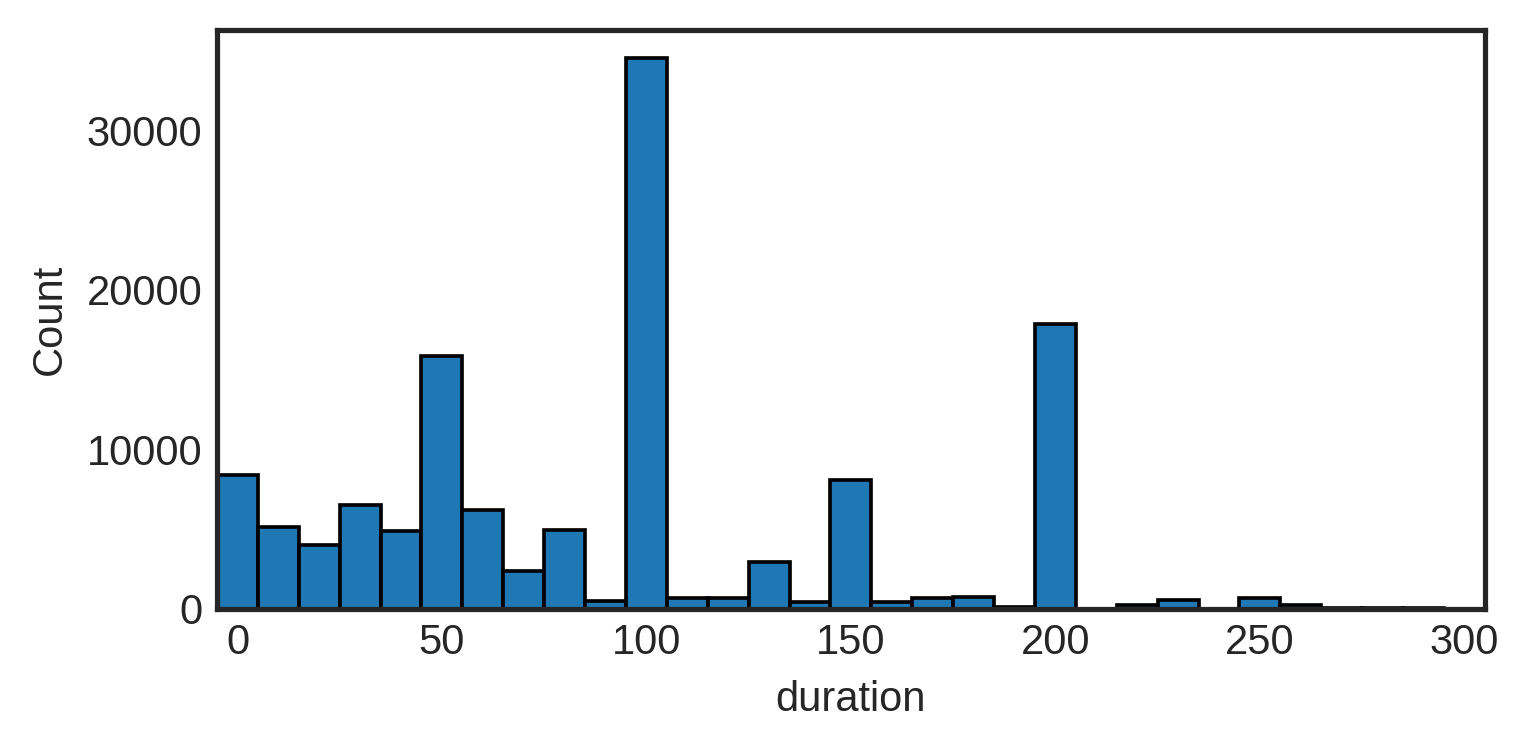

In [158]:
fig, ax = plt.subplots(figsize=(5.2, 2.6), tight_layout=True)
sns.histplot(LIRE["duration"], kde=False, bins=range(-5, 305,10), alpha=1, color="tab:blue", ax=ax)
ax.set_xlim(-5, 305)

# Random dates and overall simulations

In [159]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
LIRE["random_dates"] = LIRE.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000,), axis=1)

CPU times: user 1min 19s, sys: 594 ms, total: 1min 19s
Wall time: 1min 19s


In [160]:
%%time
LIRE_complete_simulations = tempun.timeblocks_from_randoms(LIRE, "random_dates", [-50, 350, 50])

CPU times: user 8.02 s, sys: 0 ns, total: 8.02 s
Wall time: 8.02 s


In [161]:
LIRE_complete_simulations[0]

[((-50, -1), 5285),
 ((1, 50), 20073),
 ((51, 100), 20475),
 ((101, 150), 22373),
 ((151, 200), 22100),
 ((201, 250), 18081),
 ((251, 300), 9991),
 ((301, 350), 8024)]

In [162]:
LIRE_complete_merged = tempun.simulations_merged(LIRE_complete_simulations)

In [163]:
len(LIRE_complete_merged)

8

In [164]:
print(LIRE_complete_merged[0][:50])

((-50, -1), [5285, 5198, 5193, 5253, 5195, 5189, 5210, 5284, 5285, 5230, 5162, 5236, 5280, 5296, 5288, 5250, 5255, 5189, 5265, 5263, 5232, 5280, 5289, 5253, 5263, 5331, 5249, 5230, 5351, 5231, 5222, 5274, 5349, 5210, 5333, 5252, 5252, 5287, 5238, 5276, 5271, 5354, 5243, 5325, 5204, 5191, 5253, 5250, 5209, 5288, 5247, 5265, 5320, 5285, 5236, 5261, 5322, 5251, 5391, 5281, 5213, 5271, 5251, 5310, 5283, 5256, 5241, 5290, 5234, 5329, 5343, 5312, 5172, 5249, 5246, 5220, 5358, 5321, 5276, 5273, 5283, 5260, 5248, 5325, 5238, 5284, 5263, 5293, 5308, 5325, 5250, 5222, 5200, 5239, 5253, 5342, 5249, 5250, 5258, 5262])


In [165]:
# periods definitions

periods = { # to avoid overlaps, startdates are postponed by one year, when needed
    "Julio-Claudian" : {"startdate": -27, "enddate" : 68},
    "Flavian" : {"startdate": 69, "enddate": 96},
    "Nerva-Antonine" : {"startdate" : 97, "enddate" : 192},
    "Severan" : {"startdate": 193, "enddate": 235},
    "Barracks emperors" : {"startdate" : 236, "enddate" : 284},
    "Tetrarchy\n& Constantine I" : {"startdate" : 285, "enddate" : 337}
    }
timeblocks_periods = [(periods[period]["startdate"], periods[period]["enddate"]) for period in periods]
timeblocks_periods

[(-27, 68), (69, 96), (97, 192), (193, 235), (236, 284), (285, 337)]

In [166]:
colors_list = [color for color in list(mcolors.CSS4_COLORS.keys()) if "light" in color][2:]
colors_list

['lightcyan',
 'lightgoldenrodyellow',
 'lightgray',
 'lightgreen',
 'lightgrey',
 'lightpink',
 'lightsalmon',
 'lightseagreen',
 'lightskyblue',
 'lightslategray',
 'lightslategrey',
 'lightsteelblue',
 'lightyellow']

In [167]:
periods_duration = [abs(tup[1] - tup[0]) for tup in timeblocks_periods]
periods_duration

[95, 27, 95, 42, 48, 52]

In [168]:
%%time
var_data = []
for var_n in range(1000):
    var_data.append([var[var_n] for var in LIRE["random_dates"] if var !=None])

CPU times: user 1min 18s, sys: 164 ms, total: 1min 18s
Wall time: 1min 18s


# Deities over time

In [169]:
type_dict = dict(LIRE[LIRE["asclepius"]].groupby("type_of_inscription_auto", dropna=False).size()) 
type_dict

{'building/dedicatory inscription': 10,
 'defixio': 1,
 'epitaph': 8,
 'honorific inscription': 2,
 'votive inscription': 176,
 nan: 13}

In [248]:
def get_vars_FAST(df_whole, deity):
    df_part = df_whole[df_whole[deity]]
    df_sample = pd.DataFrame()
    type_dict = dict(df_part.groupby("type_of_inscription_auto", dropna=False).size()) # groups, including Nones
    for key in type_dict.keys():
        if isinstance(key, float): # if nan
            df_type = df_whole[df_whole["type_of_inscription_auto"].isnull()].sample(type_dict[key])
        else:
            df_type = df_whole[df_whole["type_of_inscription_auto"]==key].sample(type_dict[key])
        df_sample = pd.concat([df_sample, df_type])
    var_data_deity, var_data_deity_control, tb_data, tb_data_control = [], [], [], [] 
    timeblocks = tempun.get_timeblocks(-50, 350, 25)
    for var_n in range(1000):
        var_data = [var[var_n] for var in df_part["random_dates"] if var !=None]
        var_data_deity.append(var_data)
        tb_var_data = tempun.dates_per_block(var_data, timeblocks)
        tb_data.append(tb_var_data)
        var_data_control = [var[var_n] for var in df_sample["random_dates"] if var !=None]
        var_data_deity_control.append(var_data_control)
        tb_var_data_control = tempun.dates_per_block(var_data_control, timeblocks)
        tb_data_control.append(tb_var_data_control)
    return var_data_deity, var_data_deity_control, tb_data, tb_data_control

In [275]:
def get_vars(df_whole, deity):
    df_part = df_whole[df_whole[deity]]
    type_dict = dict(df_part.groupby("type_of_inscription_auto", dropna=False).size()) # groups, including Nones
    var_data_deity, var_data_deity_control, tb_data, tb_data_control = [], [], [], [] 
    timeblocks = tempun.get_timeblocks(-50, 350, 25)
    for var_n in range(1000):
        var_data = [var[var_n] for var in df_part["random_dates"] if var !=None]
        var_data_deity.append(var_data)
        tb_var_data = tempun.dates_per_block(var_data, timeblocks)
        tb_data.append(tb_var_data)
        df_sample = pd.DataFrame()
        for key in type_dict.keys():
            if isinstance(key, float): # if nan
                df_type = df_whole[df_whole["type_of_inscription_auto"].isnull()].sample(type_dict[key], random_state=var_n)
            else:
                df_type = df_whole[df_whole["type_of_inscription_auto"]==key].sample(type_dict[key], random_state=var_n)
            df_sample = pd.concat([df_sample, df_type])
        var_data_control = [var[var_n] for var in df_sample["random_dates"] if var !=None]
        var_data_deity_control.append(var_data_control)
        tb_var_data_control = tempun.dates_per_block(var_data_control, timeblocks)
        tb_data_control.append(tb_var_data_control)
    return var_data_deity, var_data_deity_control, tb_data, tb_data_control

In [285]:
%%time
var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control = get_vars(LIRE, "asclepius")
var_data_apollo, var_data_apollo_control, tb_data_apollo, tb_data_apollo_control = get_vars(LIRE, "apollo")
var_data_jupiter, var_data_jupiter_control, tb_data_jupiter, tb_data_jupiter_control = get_vars(LIRE, "jupiter")

CPU times: user 32min 18s, sys: 50.7 s, total: 33min 9s
Wall time: 33min 9s


In [277]:
asclep_temp_data = [var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control]

In [287]:
def pickle_data(data, filepath):
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

pickle_data([var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control], "../data/large_files/asclep_temp_data.pkl")
pickle_data([var_data_apollo, var_data_apollo_control, tb_data_apollo, tb_data_apollo_control], "../data/large_files/apollo_temp_data.pkl")
pickle_data([var_data_jupiter, var_data_jupiter_control, tb_data_jupiter, tb_data_jupiter_control], "../data/large_files/jupiter_temp_data.pkl")

In [283]:
### uncomment to read back previously generated and saved data

#data = pickle.load(open('../data/large_files/asclep_temp_data.pkl', 'rb'))
#var_data_asclep, var_data_asclep_control, tb_data_asclep, tb_data_asclep_control = data[0], data[1], data[2], data[3]

#data = pickle.load(open('../data/large_files/apollo_temp_data.pkl', 'rb'))
#var_data_apollo, var_data_apollo_control, tb_data_apollo, tb_data_apollo_control = data[0], data[1], data[2], data[3]

#data = pickle.load(open('../data/large_files/jupiter_temp_data.pkl', 'rb'))
#var_data_jupiter, var_data_jupiter_control, tb_data_jupiter, tb_data_jupiter_control = data[0], data[1], data[2], data[3]

In [288]:
print(len(var_data_asclep[0]))
print(len(var_data_apollo[0]))
print(len(var_data_jupiter[0]))

210
490
2868


In [289]:
print(len(var_data_asclep_control[0]))
print(len(var_data_apollo_control[0]))
print(len(var_data_jupiter_control[0]))

210
490
2868


CPU times: user 1min 24s, sys: 314 ms, total: 1min 24s
Wall time: 1min 24s


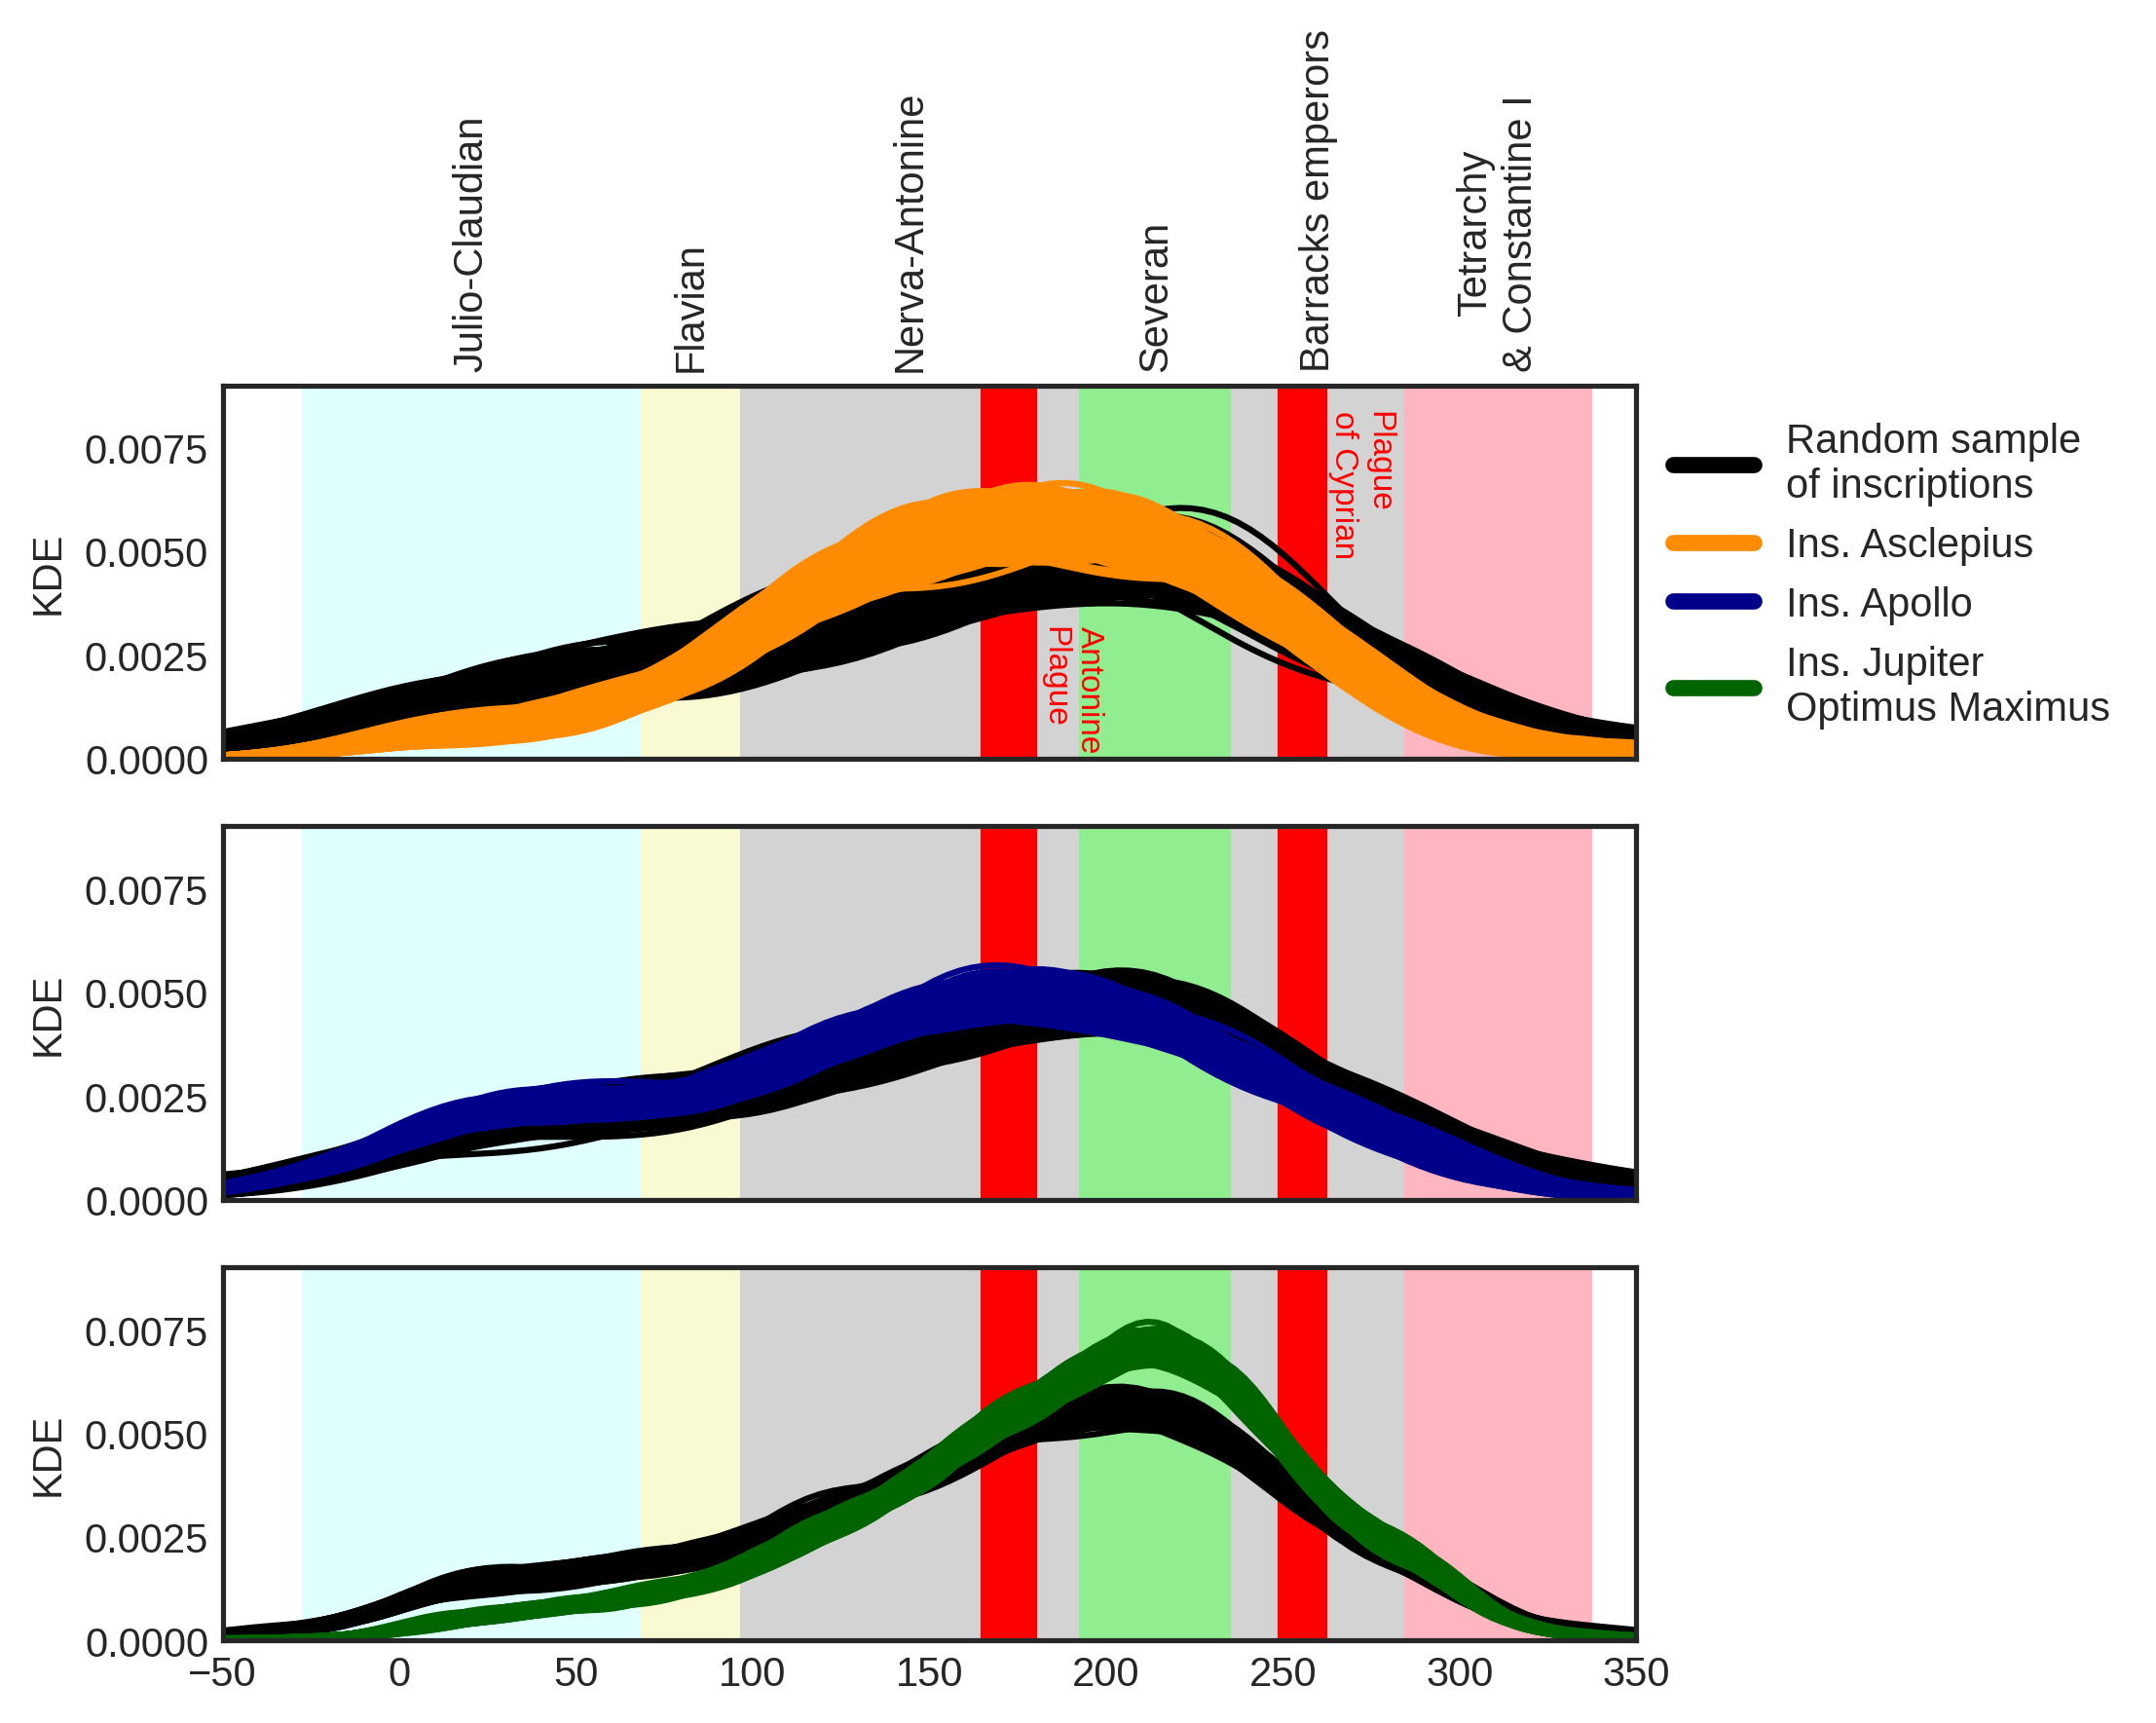

In [290]:
%%time 

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
#plt.rcParams['font.family'] = "sans-serif"
#plt.rcParams['font.sans-serif'] = "Arial"
#plt.rcParams['font.size'] = 8

# timeconsuming, because of the KDE involved
n_sims = 1000
labels=[key for key in periods.keys()]
positions = [np.mean(tup) for tup in timeblocks_periods]

#positions = [np.mean(tup[0]) for tup in occups_ratios_merged]

fig, [ax1,ax2,ax3] = plt.subplots(3,1, figsize=[7.48, 6], tight_layout=True)

### ax1 - Asclepius
for period, color in zip(periods.keys(), colors_list):
    ax1.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")
# period labels
ax1.set_xticks(positions)
ax1.set_xticklabels(labels)
ax1.xaxis.set_tick_params(rotation=90)
ax1.xaxis.tick_top()

for data in var_data_asclep_control[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="black", alpha=0.5)
for data in var_data_asclep[:n_sims]:
    sns.kdeplot(data, ax=ax1, color="darkorange", alpha=0.5)

    ax1.set_xlim(-50,350)
ax1.set_ylabel("KDE")
ax1.set_ylim(0, 0.009)


ax1.axvspan(165, 180, color="red")
ax1.annotate("Antonine\nPlague", xy=(181,0.0003), xycoords='data', color="red", rotation=270, fontsize=8)


ax1.axvspan(249, 262, color="red")
ax1.annotate("Plague\nof Cyprian", xy=(263,0.005), xycoords='data', color="red", rotation=270, fontsize=8)

### ax2 - Apollo
for period, color in zip(periods.keys(), colors_list):
    ax2.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)#, linestyles="dashed", color="red")


for data in var_data_apollo_control[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="black", alpha=0.5)
for data in var_data_apollo[:n_sims]:
    sns.kdeplot(data, ax=ax2, color="darkblue", alpha=0.5)
    
ax2.set_xlim(-50,350)
ax2.set_ylabel("KDE")
ax2.set_ylim(0, 0.009)
ax2.set_xticks([])

ax2.axvspan(165, 180, color="red")
ax2.axvspan(249, 262, color="red")

### ax3 - Jupyter
for period, color in zip(periods.keys(), colors_list):
    ax3.axvspan(periods[period]["startdate"], periods[period]["enddate"], color=color)

for data in var_data_jupiter_control[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="black", alpha=0.5)
for data in var_data_jupiter[:n_sims]:
    sns.kdeplot(data, ax=ax3, color="darkgreen", alpha=0.5)    
ax3.set_xlim(-50,350)
ax3.set_ylabel("KDE")
ax3.set_ylim(0, 0.009)

ax3.axvspan(165, 180, color="red")
ax3.axvspan(249, 262, color="red")

markers = [plt.Line2D([0,0],[0,0],color=color, lw=4) for color in ["black", "darkorange", "darkblue", "darkgreen"]]
ax1.legend(markers, ["Random sample\nof inscriptions", "Ins. Asclepius", "Ins. Apollo", "Ins. Jupiter\nOptimus Maximus"], bbox_to_anchor=(1, 1), loc='upper left')


In [291]:
s = sddk.cloudSession("sciencedata.dk", "SDAM_root", "648597@au.dk")

Your ScienceData username (e.g. '123456@au.dk'): 648597@au.dk
Your ScienceData password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [292]:
#sddk.write_file(figpath + "comparing_distributions_kde.eps", fig, conf)
figpath = "SDAM_data/ASCNET/ASCNET_figures/"
s.write_file(figpath + "comparing_distributions_kde.png", fig)
s.write_file(figpath + "comparing_distributions_kde.eps", fig)

A file with the same name ("comparing_distributions_kde.png") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ASCNET/ASCNET_figures/comparing_distributions_kde.png"
A file with the same name ("comparing_distributions_kde.eps") already exists in this location.
Press Enter to overwrite it or choose different path and filename: 
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ASCNET/ASCNET_figures/comparing_distributions_kde.eps"


# Statistical comparison


We use two-sample Kolmogorov-Smirnov test, which checks whether  two data samples come from the same distribution. This does not specify what that common distribution is (e.g. whether it's normal or not normal).  

We employ it to compare distribution of all iscriptions mentioning the deity against a distribution based on a random sample of inscriptions of the same length and of the same proportion of inscription types. We repeat this procedure for all dating simulations and evaluate the consinstency of the findings.

In [293]:
# average p_value for two samples from the same distribution
avg_p = np.mean([scipy.stats.ks_2samp(var_data_asclep[int(np.random.random()*1000)], var_data_asclep[int(np.random.random()*1000)]).pvalue for n in range(1,1000)])
avg_p

0.8118312425835542

In [294]:
# average KS_statistic p_value for two samples
p_values = np.mean([scipy.stats.ks_2samp(var_data_asclep[n], var_data_asclep_control[n]).pvalue for n in range(0,1000)])
KS_statistic = np.mean([scipy.stats.ks_2samp(var_data_asclep[n], var_data_asclep_control[n]).statistic for n in range(0,1000)])
print("KS_statistic={0}, p={1}".format(KS_statistic, p_values))

KS_statistic=0.11272380952380952, p=0.20010169033526712


In [295]:
def ks_per_samplesets(sampleset, sampleset_control, subsample_len=None):
    if subsample_len == None:
        subsample_len = len(sampleset[0])
    KS_statistic = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).statistic for n in range(0,1000)]), 4)
    p_values = np.round(np.mean([scipy.stats.ks_2samp(sampleset[n][:subsample_len], sampleset_control[n][:subsample_len]).pvalue for n in range(0,1000)]), 4)
    return KS_statistic, p_values

In [296]:
ks_per_samplesets(var_data_asclep, var_data_asclep_control)

(0.1127, 0.2001)

In [297]:
ks_per_samplesets(var_data_apollo, var_data_apollo_control)

(0.1006, 0.0571)

In [298]:
ks_per_samplesets(var_data_apollo, var_data_apollo_control, 210)

(0.1029, 0.2826)

In [299]:
ks_per_samplesets(var_data_jupiter, var_data_jupiter_control)

(0.1119, 0.0)

In [300]:
ks_per_samplesets(var_data_jupiter, var_data_jupiter_control, 210)

(0.183, 0.0111)

In [332]:
print("hello")

hello


In [301]:
ks_per_samplesets(var_data_asclep, var_data_apollo, 210)

(0.0825, 0.4984)

In [302]:
ks_per_samplesets(var_data_asclep, var_data_jupiter, 210)

(0.1612, 0.023)

In [303]:
ks_per_samplesets(var_data_apollo, var_data_jupiter, 210)

(0.1685, 0.0145)

# Comparing differences over timeblocks

In [254]:
tb_data_asclep_merged = tempun.simulations_merged(tb_data_asclep)
tb_data_asclep_control_merged = tempun.simulations_merged(tb_data_asclep_control)

In [264]:
len(tb_data_asclep_control_merged[13][1])

1000

In [270]:
def calc_diff(list1, list2):
    return np.array(list1) - np.array(list2)

diffs_lists = []
for tb_ind in range(len(tb_data_asclep_merged)):
    tb = tb_data_asclep_merged[tb_ind]
    tb_control = tb_data_asclep_control_merged[tb_ind]
    diff_array = calc_diff(tb[1], tb_control[1])
    diffs_lists.append(diff_array)
    print(tb_data_asclep_merged[tb_ind][0], np.mean(diff_array), np.std(diff_array))

(-50, -26) -1.984 0.7821406523126132
(-25, -1) -0.463 0.8914207760648166
(1, 25) -2.406 2.762094133080913
(26, 50) -5.24 2.7706316969240063
(51, 75) -3.343 3.2651724303625986
(76, 100) -1.29 3.750719930893268
(101, 125) 5.152 5.212379111308002
(126, 150) 4.276 5.43505510551641
(151, 175) 5.774 5.68954514877947
(176, 200) 5.664 5.95509059544857
(201, 225) -0.432 5.6518471316906655
(226, 250) 4.313 5.117912758146625
(251, 275) -1.616 4.190768903196644
(276, 300) -4.028 3.2201267055816296
(301, 325) -1.603 1.510427422950206
(326, 350) -0.725 1.4069026263391506


In [305]:
diffs_lists[0][:20]

array([-2, -1, -2, -2, -1, -2, -2, -2, -1, -2, -1, -1, -1, -2, -3, -2, -3,
       -2, -3, -1])

In [306]:
np.mean(diffs_lists[0])

-1.984

In [307]:
np.median(diffs_lists[0])

-2.0

In [313]:
tbs = tempun.get_timeblocks(-50, 350, 25)
print(tbs)

[(-50, -26), (-25, -1), (1, 25), (26, 50), (51, 75), (76, 100), (101, 125), (126, 150), (151, 175), (176, 200), (201, 225), (226, 250), (251, 275), (276, 300), (301, 325), (326, 350)]


In [319]:
tb_labels = []
for tb in tbs:
    if tb[1] < 0:
        tb_label = "{0}-{1} BCE".format(str(abs(tb[0])), str(abs(tb[1])))
    else:
        tb_label = "{0}-{1} CE".format(str(tb[0]), str(tb[1]))
    tb_labels.append(tb_label)
                    

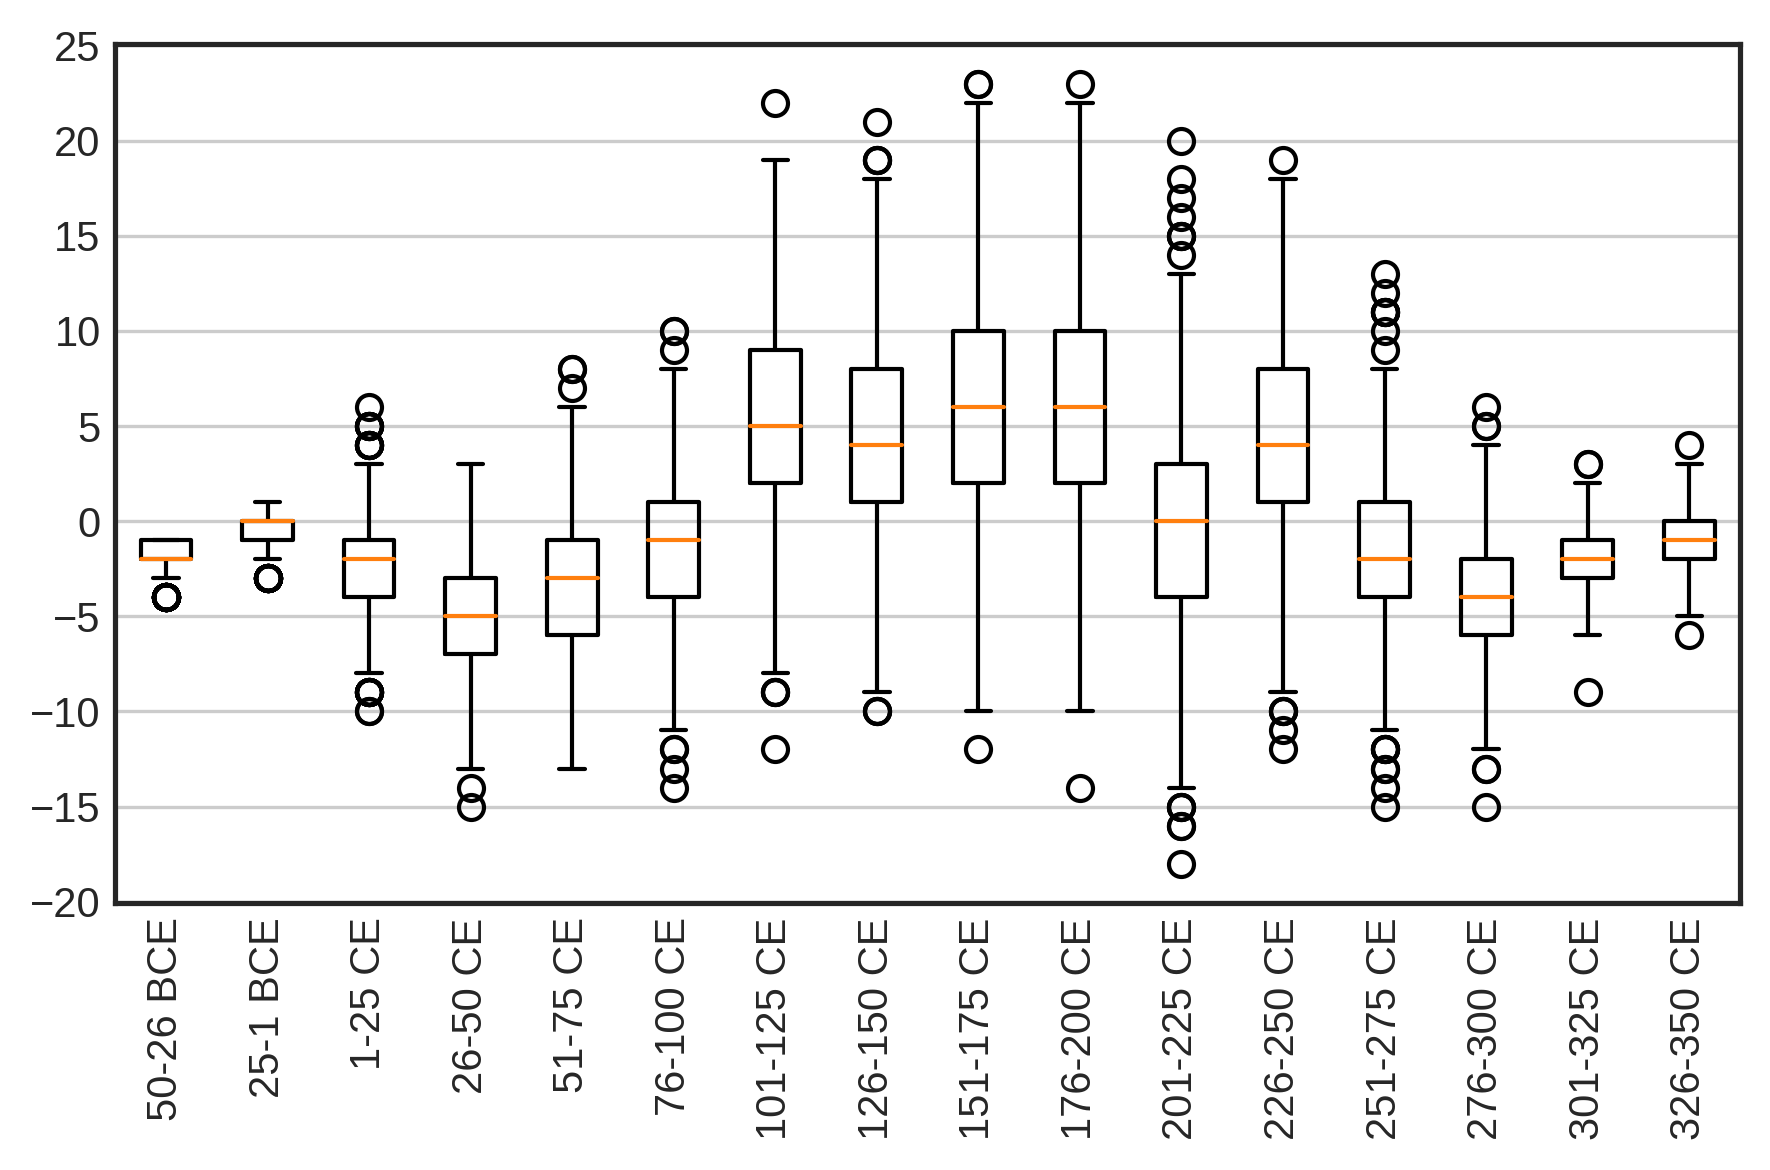

In [325]:
fig, ax = plt.subplots(tight_layout=True)
ax.boxplot(diffs_lists)
ax.set_xticklabels(tb_labels, rotation=90)
ax.set_yticks(range(-20, 30, 5))
ax.grid(axis="y")
plt.show()

In [329]:
def calc_diff_ratio(list1, list2):
    return np.array(list1) / np.array(list2)

diffs_lists_ratio = []
for tb_ind in range(len(tb_data_asclep_merged)):
    tb = tb_data_asclep_merged[tb_ind]
    tb_control = tb_data_asclep_control_merged[tb_ind]
    diff_array = calc_diff_ratio(tb[1], tb_control[1])
    diffs_lists_ratio.append(diff_array)
    print(tb_data_asclep_merged[tb_ind][0], np.mean(diff_array), np.std(diff_array))

(-50, -26) 0.0 0.0
(-25, -1) 0.89625 0.49088196561563213
(1, 25) 0.7427165501165501 0.48649613602030894
(26, 50) 0.42589012654012653 0.23852269606082663
(51, 75) 0.6949624673529086 0.37346555202190723
(76, 100) 0.951562708017256 0.36701072953889924
(101, 125) 1.3291092562988411 0.3488934400217386
(126, 150) 1.2595584349099849 0.3320170017520615
(151, 175) 1.263201634226956 0.2683478462083055
(176, 200) 1.2532742235654022 0.2753126255199452
(201, 225) 1.0048425607780156 0.2166010768674421
(226, 250) 1.2206380723950951 0.26049911564883477
(251, 275) 0.9325038338252735 0.34360995621325535
(276, 300) 0.5907282883782884 0.36666834376732266
(301, 325) nan nan
(326, 350) nan nan


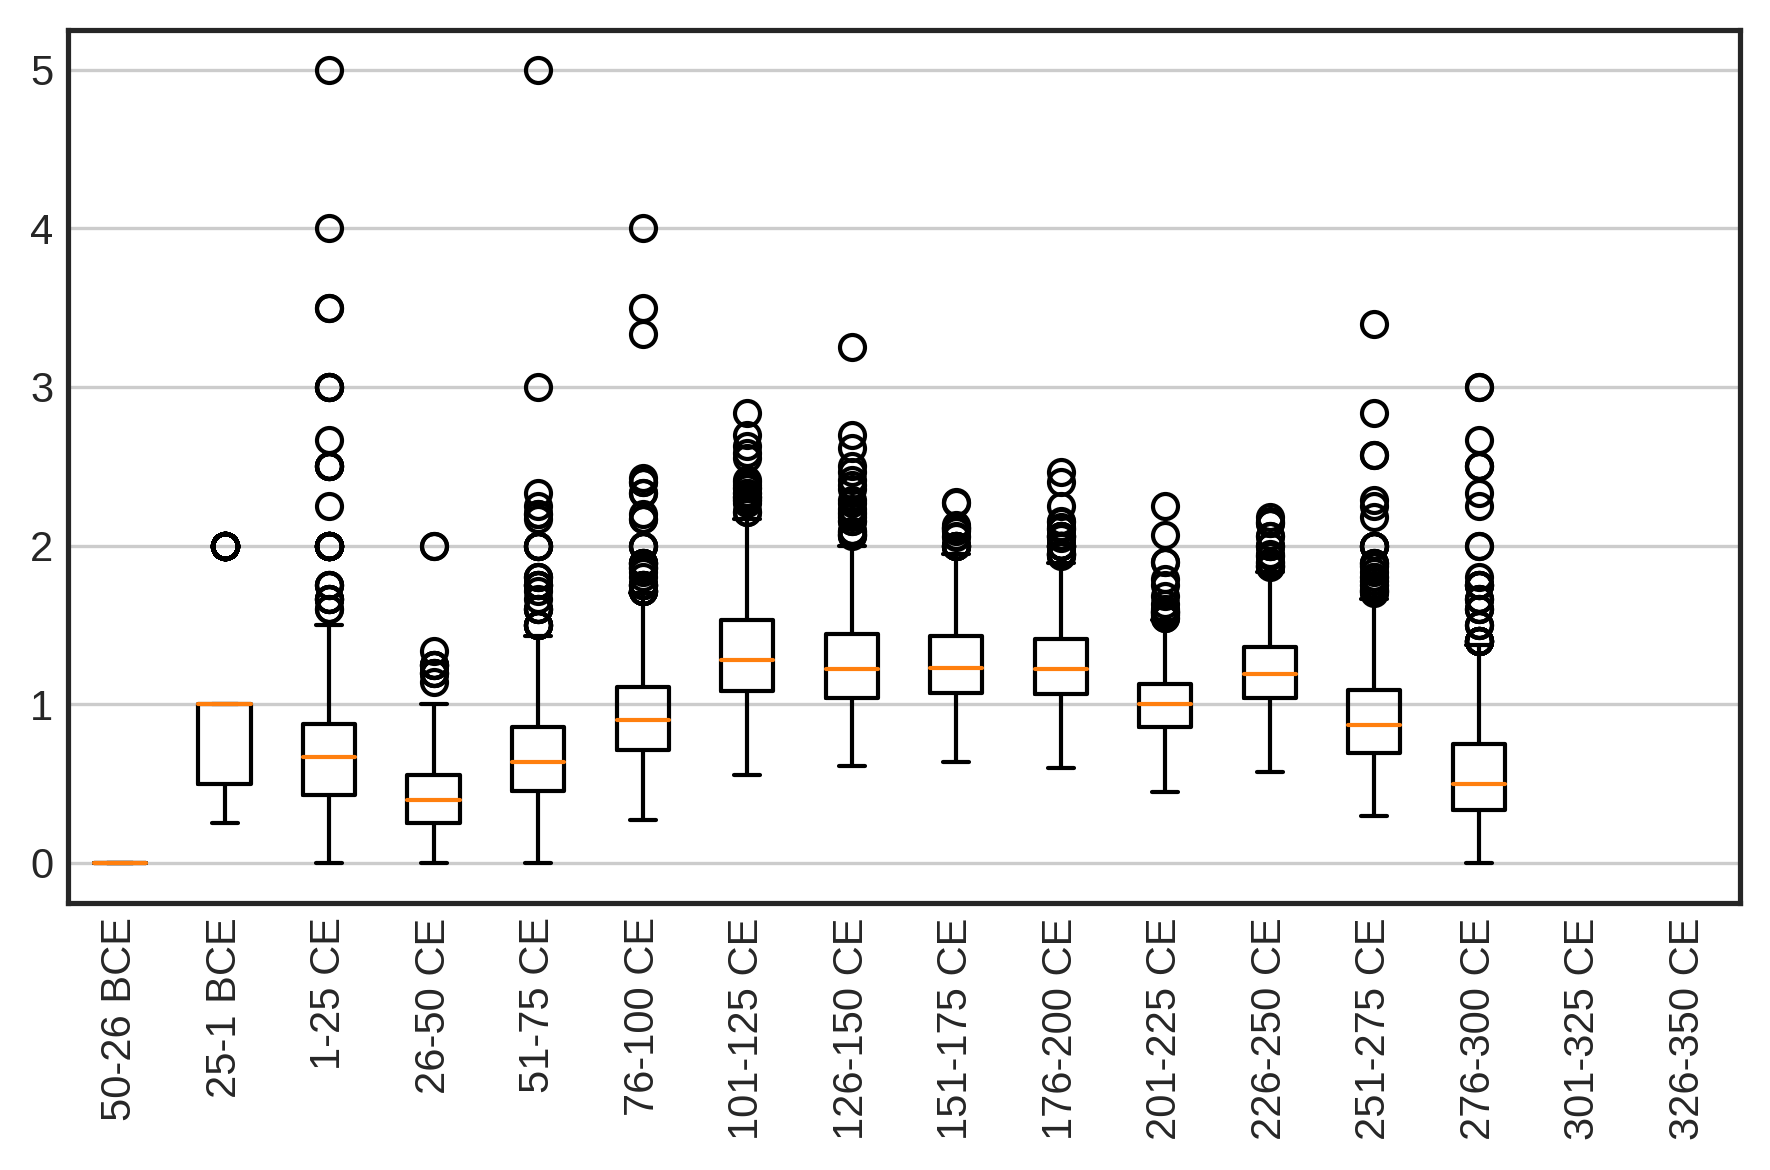

In [334]:
fig, ax = plt.subplots(tight_layout=True)
ax.boxplot(diffs_lists_ratio)
ax.set_xticklabels(tb_labels, rotation=90)
#ax.set_yticks(range(-20, 30, 5))
ax.grid(axis="y")
plt.show()

In [335]:
figpath = "SDAM_data/ASCNET/ASCNET_figures/"
s.write_file(figpath + "ratios_per_tbs.png", fig)
s.write_file(figpath + "ratios_per_tbs.eps", fig)

Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ASCNET/ASCNET_figures/ratios_per_tbs.png"
Your <class 'matplotlib.figure.Figure'> object has been succefully written as "https://sciencedata.dk/files/SDAM_root/SDAM_data/ASCNET/ASCNET_figures/ratios_per_tbs.eps"


In [352]:
pd.Series(diffs_lists_ratio[2]).describe()

count    1000.000000
mean        0.742717
std         0.486740
min         0.000000
25%         0.428571
50%         0.666667
75%         0.875000
max         5.000000
dtype: float64

In [353]:
np.median(diffs_lists_ratio[2])

0.6666666666666666